# Hypertune cifar10

In [4]:
from loguru import logger
import ray
from pathlib import Path

DATADIR = ("data/raw/cifar10/")
TUNEDIR = ("hypertune")
MODELS_DIR = Path("./saved_models")


In [5]:
from torchvision import datasets, transforms
from loguru import logger
from pathlib import Path

# Ensure the data directory exists before downloading dataset
data_dir = Path(DATADIR).resolve()
if not data_dir.exists():
    data_dir.mkdir(parents=True)
    logger.info(f"Created {data_dir}")

tune_dir = Path(TUNEDIR).resolve()
if not tune_dir.exists():
    tune_dir.mkdir(parents=True)
    logger.info(f"Created {tune_dir}")

# Create transformer to convert images to tensors
transformer = transforms.Compose([transforms.ToTensor()])

# Download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer)
test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

logger.info(
    f"Dataset is now available:\n"
    f"TRAIN: {train_dataset}\n"
    f"TEST: {test_dataset}"
)

2025-10-30 08:22:21.872 | INFO     | __main__:<module>:23 - Dataset is now available:
TRAIN: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
TEST: Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [6]:
classes = train_dataset.classes
logger.info(f"Classes: {classes}")

2025-10-30 08:22:21.877 | INFO     | __main__:<module>:2 - Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
from torch.utils.data import DataLoader

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inspect the shape of a batch of training data
for images, labels in train_loader:
    logger.info(f"Image batch dimensions: {images.shape}")
    logger.info(f"Image label dimensions: {labels.shape}")
    break

2025-10-30 08:22:21.903 | INFO     | __main__:<module>:9 - Image batch dimensions: torch.Size([64, 3, 32, 32])
2025-10-30 08:22:21.903 | INFO     | __main__:<module>:10 - Image label dimensions: torch.Size([64])


In [8]:
def get_data_loaders(batch_size, data_dir):
    from filelock import FileLock
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader

    with FileLock(data_dir / ".lock"):
        # Create transformer to convert images to tensors
        transformer = transforms.Compose([transforms.ToTensor()])

        # Download CIFAR10 dataset
        train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer, )
        test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return train_loader, test_loader

def get_data_loaders_transforms(batch_size, data_dir):
    from filelock import FileLock
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader

    with FileLock(data_dir / ".lock"):
        # Create transformer to convert images to tensors
        transformer = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # random zoom
            transforms.RandomHorizontalFlip(),                   # random flip
            transforms.ToTensor()
        ])

        # Download CIFAR10 dataset
        train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transformer, )
        test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transformer)

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    return train_loader, test_loader

In [9]:
import torch
from pathlib import Path

config = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "hidden_size": 128,
    "dropout": 0,
    "num_layers": 5,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu", 
}

In [10]:
# Setup for simple neural network with learning curve plotting

import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt

class SimpleNN(nn.Module):
    """
    A simple feedforward neural network for image classification.

    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in hidden layers.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_layers (int): Number of hidden layers.

    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
        plot_learning_curve(): Plots the learning curve (loss and accuracy).
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers, use_residual=False, use_batchnorm=False):
        super(SimpleNN, self).__init__()
        self.input_size = input_size
        self.use_residual = use_residual
        self.use_batchnorm = use_batchnorm
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        # Flatten input image
        layers.append(nn.Flatten())
        # First linear layer from input to hidden
        layers.append(nn.Linear(input_size * 32 * 32, hidden_size))
        if self.use_batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Additional hidden layers with optional residual and batchnorm
        for i in range(num_layers - 1):
            linear = nn.Linear(hidden_size, hidden_size)
            block = [linear]
            if self.use_batchnorm:
                block.append(nn.BatchNorm1d(hidden_size))
            block.append(nn.ReLU())
            block.append(nn.Dropout(dropout))
            if self.use_residual:
                # Residual block as a custom nn.Module
                block = [ResidualBlock(hidden_size, block)]
            layers.extend(block)

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).

        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))

    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, block_layers):
        super().__init__()
        self.block = nn.Sequential(*block_layers)
        self.hidden_size = hidden_size

    def forward(self, x):
        return x + self.block(x)


model_NN = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"]
)

# Show a summary of the model architecture
model_NN.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 3072]                --
├─Linear: 1-2                            [-1, 128]                 393,344
├─ReLU: 1-3                              [-1, 128]                 --
├─Dropout: 1-4                           [-1, 128]                 --
├─Linear: 1-5                            [-1, 128]                 16,512
├─ReLU: 1-6                              [-1, 128]                 --
├─Dropout: 1-7                           [-1, 128]                 --
├─Linear: 1-8                            [-1, 128]                 16,512
├─ReLU: 1-9                              [-1, 128]                 --
├─Dropout: 1-10                          [-1, 128]                 --
├─Linear: 1-11                           [-1, 128]                 16,512
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 -

In [43]:
from tqdm import tqdm
import torch

def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_evaluate(model, config, logger, model_name):
    # Directory to save models
    save_dir = MODELS_DIR
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{model_name}.pth"

    # Try to load model if exists
    if save_path.exists():
        model.load_state_dict(torch.load(save_path))
        logger.info(f"Loaded {model_name} weights from {save_path}")
        return model, None

    train_loader, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")

    # Save model after training
    torch.save(model.state_dict(), save_path)
    logger.info(f"Saved {model_name} weights to {save_path}")

    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]

def train_and_evaluate_transforms(model, config, logger, model_name="model"):
    # Directory to save models
    save_dir = MODELS_DIR
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f"{model_name}.pth"

    # Try to load model if exists
    if save_path.exists():
        model.load_state_dict(torch.load(save_path))
        logger.info(f"Loaded {model_name} weights from {save_path}")
        return model, None
    train_loader, test_loader = get_data_loaders_transforms(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]
    if not hasattr(model, "train_losses"):
        model.train_losses = []
    if not hasattr(model, "val_losses"):
        model.val_losses = []
    if not hasattr(model, "train_accuracies"):
        model.train_accuracies = []
    if not hasattr(model, "val_accuracies"):
        model.val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    # Save model after training
    torch.save(model.state_dict(), save_path)
    logger.info(f"Saved {model_name} weights to {save_path}")

    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]

def plot_confusion_matrix(model, config, classes):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    _, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='viridis')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

def show_images_with_predictions(model, config, classes, num_images=5):
    import matplotlib.pyplot as plt
    import numpy as np

    _, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    model.eval()

    correct_images = []
    correct_labels = []
    correct_preds = []

    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(images.size(0)):
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                true_label = classes[labels[i]]
                pred_label = classes[predicted[i]]
                if predicted[i] == labels[i]:
                    if len(correct_images) < 5:
                        correct_images.append(img)
                        correct_labels.append(true_label)
                        correct_preds.append(pred_label)
                else:
                    if len(incorrect_images) < 5:
                        incorrect_images.append(img)
                        incorrect_labels.append(true_label)
                        incorrect_preds.append(pred_label)
            if len(correct_images) >= 5 and len(incorrect_images) >= 5:
                break

    # Plot correct predictions
    plt.figure(figsize=(15, 3))
    for idx, img in enumerate(correct_images):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.title(f"T:{correct_labels[idx]}\nP:{correct_preds[idx]}")
        plt.axis('off')
    plt.suptitle("Correct Predictions", y=1.15)
    plt.tight_layout()
    plt.show()

    # Plot incorrect predictions
    plt.figure(figsize=(15, 3))
    for idx, img in enumerate(incorrect_images):
        plt.subplot(1, 5, idx + 1)
        plt.imshow(img)
        plt.title(f"T:{incorrect_labels[idx]}\nP:{incorrect_preds[idx]}")
        plt.axis('off')
    plt.suptitle("Incorrect Predictions", y=1.15)
    plt.tight_layout()
    plt.show()


2025-10-30 08:22:22.816 | INFO     | __main__:train_and_evaluate:51 - Loaded simple_nn_model weights from saved_models/simple_nn_model.pth


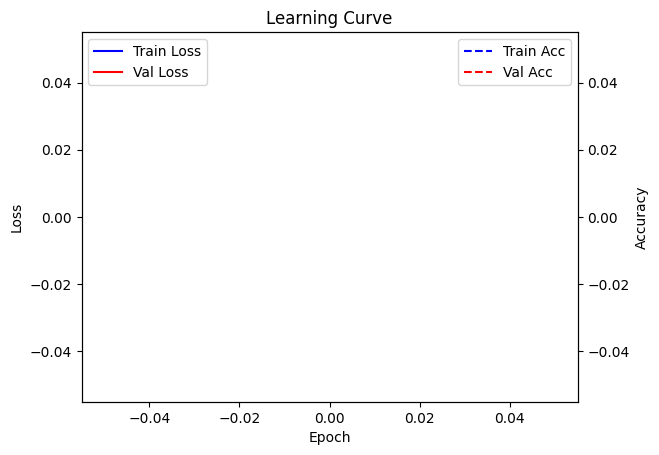

In [12]:
train_and_evaluate(model_NN, config, logger, "simple_nn_model")
model_NN.plot_learning_curve()

2025-10-30 08:22:22.980 | INFO     | __main__:train_and_evaluate:51 - Loaded simple_nn_model_with_residual weights from saved_models/simple_nn_model_with_residual.pth


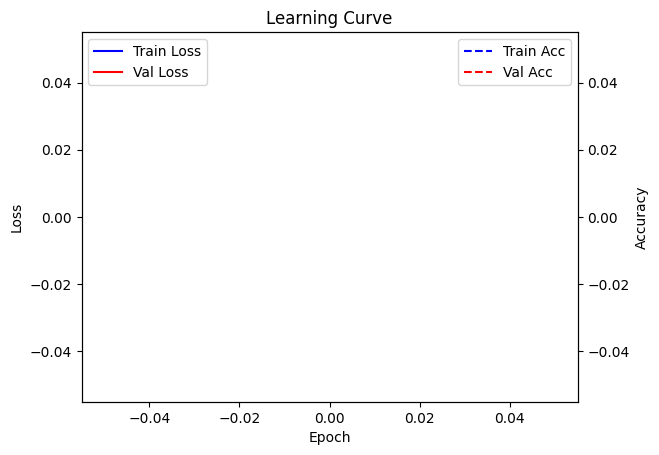

In [13]:
model_NN_with_residual = SimpleNN(
    input_size=config["input_size"],
    hidden_size=config["hidden_size"],
    output_size=config["output_size"],
    dropout=config["dropout"],
    num_layers=config["num_layers"],
    use_residual=True
)
train_and_evaluate(model_NN_with_residual, config, logger, "simple_nn_model_with_residual")
model_NN_with_residual.plot_learning_curve()

In [14]:
config_cnn = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "hidden_size": 128,
    "dropout": 0,
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # convolutional layer parameters
    "num_conv_layers": 3,
    "filters": 64,
    "kernel_size": 3,
    "stride": 1,
    "padding": 1,
    
}

In [15]:
# Setup for simple neural network
import torch.nn as nn
from torchsummary import summary

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network (CNN) for image classification.
    Args:
        input_size (int): Number of input channels (e.g., 3 for RGB images).
        hidden_size (int): Number of units in the fully connected hidden layer.
        output_size (int): Number of output classes.
        dropout (float): Dropout probability for regularization.
        num_conv_layers (int): Number of convolutional layers.
        filters (int): Number of filters in each convolutional layer.
        kernel_size (int): Size of the convolutional kernels.
        stride (int): Stride for the convolutional layers.
        padding (int): Padding for the convolutional layers.
        num_fully_connected_layers (int): Number of fully connected layers.
    Methods:
        forward(x): Forward pass through the network.
        summary(): Prints a summary of the network architecture.
        plot_learning_curve(): Plots the training/validation loss and accuracy curves.
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, num_conv_layers, filters, kernel_size, stride, padding, num_fully_connected_layers, batchnorm=False, residual=False):
        super(SimpleCNN, self).__init__()
        self.input_size = input_size
        self.batchnorm = batchnorm
        self.residual = residual
        # For learning curve
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

        layers = []
        in_channels = input_size

        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, kernel_size, stride, padding, batchnorm):
                super().__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
                self.bn1 = nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity()
                self.relu = nn.ReLU()
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding)
                self.bn2 = nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity()
                self.downsample = nn.Conv2d(in_channels, out_channels, 1, stride) if in_channels != out_channels or stride != 1 else nn.Identity()

            def forward(self, x):
                identity = self.downsample(x)
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.conv2(out)
                out = self.bn2(out)
                out += identity
                out = self.relu(out)
                return out

        # Add convolutional layers (with optional residual blocks)
        for _ in range(num_conv_layers):
            if self.residual:
                layers.append(ResidualBlock(in_channels, filters, kernel_size, stride, padding, self.batchnorm))
            else:
                layers.append(nn.Conv2d(in_channels, filters, kernel_size, stride, padding))
                if self.batchnorm:
                    layers.append(nn.BatchNorm2d(filters))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(2))
            in_channels = filters

        layers.append(nn.Flatten())

        # Dynamically compute feature size after conv/pool layers
        with torch.no_grad():
            dummy = torch.zeros(1, input_size, 32, 32)
            for layer in layers:
                dummy = layer(dummy)
            feature_size = dummy.shape[1]

        # Add the first fully connected layer
        layers.append(nn.Linear(feature_size, hidden_size))
        if self.batchnorm:
            layers.append(nn.BatchNorm1d(hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))

        # Add additional fully connected layers if num_fully_connected_layers > 1
        for _ in range(num_fully_connected_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            if self.batchnorm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        Forward pass of the network.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size, 32, 32).
        Returns:
            torch.Tensor: Output logits.
        """
        return self.network(x) 

    def summary(self):
        """
        Prints a summary of the network architecture using torchsummary.
        """
        summary(self.network, (self.input_size, 32, 32))
    
    def plot_learning_curve(self):
        """
        Plots the learning curve (loss and accuracy).
        """
        import matplotlib.pyplot as plt
        epochs = range(1, len(self.train_losses) + 1)
        fig, ax1 = plt.subplots()
        ax1.plot(epochs, self.train_losses, 'b-', label='Train Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Val Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='upper left')
        ax2 = ax1.twinx()
        ax2.plot(epochs, self.train_accuracies, 'b--', label='Train Acc')
        ax2.plot(epochs, self.val_accuracies, 'r--', label='Val Acc')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='upper right')
        plt.title('Learning Curve')
        plt.show()

model_CNN = SimpleCNN(
    input_size=config_cnn["input_size"],
    hidden_size=config_cnn["hidden_size"],
    output_size=config_cnn["output_size"],
    dropout=config_cnn["dropout"],
    num_conv_layers=config_cnn["num_conv_layers"],
    filters=config_cnn["filters"],
    kernel_size=config_cnn["kernel_size"],
    stride=config_cnn["stride"],
    padding=config_cnn["padding"],
    num_fully_connected_layers=config_cnn["num_fully_connected_layers"]
)

# Show a summary of the model architecture
model_CNN.summary(); model_CNN.summary

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-3                         [-1, 64, 16, 16]          --
├─Conv2d: 1-4                            [-1, 64, 16, 16]          36,928
├─ReLU: 1-5                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-6                         [-1, 64, 8, 8]            --
├─Conv2d: 1-7                            [-1, 64, 8, 8]            36,928
├─ReLU: 1-8                              [-1, 64, 8, 8]            --
├─MaxPool2d: 1-9                         [-1, 64, 4, 4]            --
├─Flatten: 1-10                          [-1, 1024]                --
├─Linear: 1-11                           [-1, 128]                 131,200
├─ReLU: 1-12                             [-1, 128]                 --
├─Dropout: 1-13                          [-1, 128]                 --

<bound method SimpleCNN.summary of SimpleCNN(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0, inplace=False)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): ReLU()
    (15): Dropout(p=0, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)>

2025-10-30 08:22:23.113 | INFO     | __main__:train_and_evaluate:51 - Loaded simple_cnn_model weights from saved_models/simple_cnn_model.pth


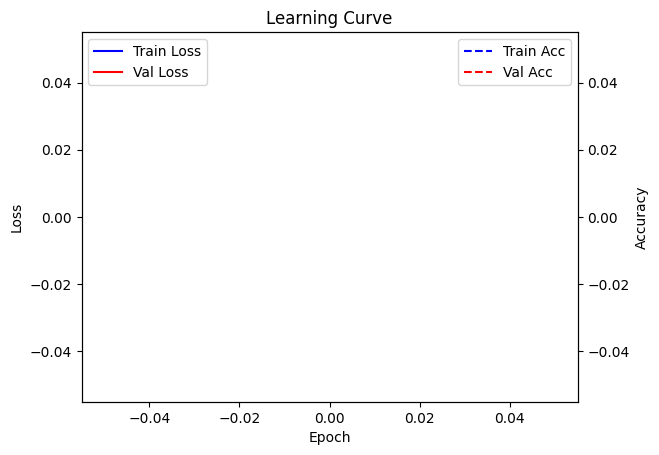

In [16]:
train_and_evaluate(model_CNN, config_cnn, logger, "simple_cnn_model")
model_CNN.plot_learning_curve()

In [17]:
from ray import tune

def train_and_evaluate_ray_transformers(config: dict):
    model = SimpleCNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["output_size"],
        dropout=config["dropout"],
        num_conv_layers=config["num_conv_layers"],
        filters=config["filters"],
        kernel_size=config["kernel_size"],
        stride=config["stride"],
        padding=config["padding"],
        num_fully_connected_layers=config["num_fully_connected_layers"]
    )
    train_loader, test_loader = get_data_loaders_transforms(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)
        
        ray.train.report({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy
        })
        # logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    

def train_and_evaluate_ray(config: dict):
    model = SimpleCNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["output_size"],
        dropout=config["dropout"],
        num_conv_layers=config["num_conv_layers"],
        filters=config["filters"],
        kernel_size=config["kernel_size"],
        stride=config["stride"],
        padding=config["padding"],
        num_fully_connected_layers=config["num_fully_connected_layers"]
    )
    train_loader, test_loader = get_data_loaders(config["batch_size"], config["data_dir"])
    device = config["device"]
    model.to(device)
    optimizer = config["optimizer"](model.parameters(), lr=config["learning_rate"])
    loss_fn = config["loss_fn"]
    num_epochs = config["epochs"]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_accuracy = evaluate(model, test_loader, loss_fn, device)

        model.train_losses.append(train_loss)
        model.val_losses.append(val_loss)
        model.train_accuracies.append(train_accuracy)
        model.val_accuracies.append(val_accuracy)
        
        ray.train.report({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy
        })
        # logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {val_accuracy:.2f}%")
    
    return model.train_losses[-1], model.val_losses[-1], model.val_accuracies[-1]


In [ ]:

config_structure = {
    # Fixed parameters
    "epochs": 3,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "hidden_size": 350,
    "dropout": 0,
    "num_fully_connected_layers": tune.grid_search([2,4]),
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    
    # convolutional layer parameters
    "num_conv_layers": tune.grid_search([2,3,4]),
    "filters": tune.grid_search([64,128,152]),
    "kernel_size": tune.grid_search([2,3]),
    "stride": 1,
    "padding": 0,
}

analysis_structure = tune.run(
    train_and_evaluate_ray,
    config=config_structure,
    name="cnn_hyperparameter_gridsearch",
    metric="val_loss",
    mode="min",
    storage_path=str(config_structure["tune_dir"]),  # ensure path is string
    stop={"training_iteration": config_structure["epochs"]},
    verbose=1,
    resume=True,
    raise_on_failed_trial=False  # This prevents TuneError from being raised
)

tune_df_structure = analysis_structure.results_df.sort_values("val_loss")
tune_df_structure.head()

2025-10-30 08:22:42,246	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-29_08-24-33.json
2025-10-30 08:22:42,669	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_gridsearch' in 0.2968s.
2025-10-30 08:22:42,681	ERROR tune.py:1037 -- Trials did not complete: [train_and_evaluate_ray_0c81f_00016, train_and_evaluate_ray_0c81f_00033, train_and_evaluate_ray_0c81f_00015, train_and_evaluate_ray_0c81f_00035, train_and_evaluate_ray_0c81f_00017, train_and_evaluate_ray_0c81f_00034]
2025-10-30 08:22:42,681	INFO tune.py:1041 -- Total run time: 0.58 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
0c81f_00002,0.814518,0.891974,71.030,68.24,1.761594e+09,NaN,True,3.0,2025-10-27_20-31-52,499.112931,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,2.0,1.0,0.0
0c81f_00001,0.877214,0.914536,68.920,68.29,1.761593e+09,NaN,True,3.0,2025-10-27_20-26-38,496.922892,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0
0c81f_00004,0.911675,0.917889,67.900,67.90,1.761593e+09,NaN,True,3.0,2025-10-27_20-27-34,511.481281,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0
0c81f_00000,0.905180,0.927922,67.636,67.41,1.761592e+09,NaN,True,3.0,2025-10-27_20-12-40,242.827116,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,64.0,2.0,1.0,0.0
0c81f_00019,0.889029,0.930195,68.488,67.89,1.761593e+09,NaN,True,3.0,2025-10-27_20-28-08,507.948703,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0


(raylet) [2025-10-30 09:58:16,364 E 4172513 4172539] (raylet) file_system_monitor.cc:116: /tmp/ray/session_2025-10-30_08-22-25_759219_4168839 is over 95% full, available space: 0.232365 GB; capacity: 4.84341 GB. Object creation will fail if spilling is required.


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(df, x, y, z):
    # Pivot the dataframe to create a matrix for heatmap
    heatmap_data = df.pivot_table(index=y, columns=x, values=z)
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto', origin='lower')

    # Show all ticks and label them
    ax.set_xticks(np.arange(len(heatmap_data.columns)))
    ax.set_yticks(np.arange(len(heatmap_data.index)))
    ax.set_xticklabels(heatmap_data.columns)
    ax.set_yticklabels(heatmap_data.index)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"Heatmap of {z} by {x} and {y}")

    # Annotate each cell with the accuracy value
    for i in range(len(heatmap_data.index)):
        for j in range(len(heatmap_data.columns)):
            value = heatmap_data.iloc[i, j]
            if not np.isnan(value):
                ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

    plt.colorbar(im, label=z)
    plt.show()


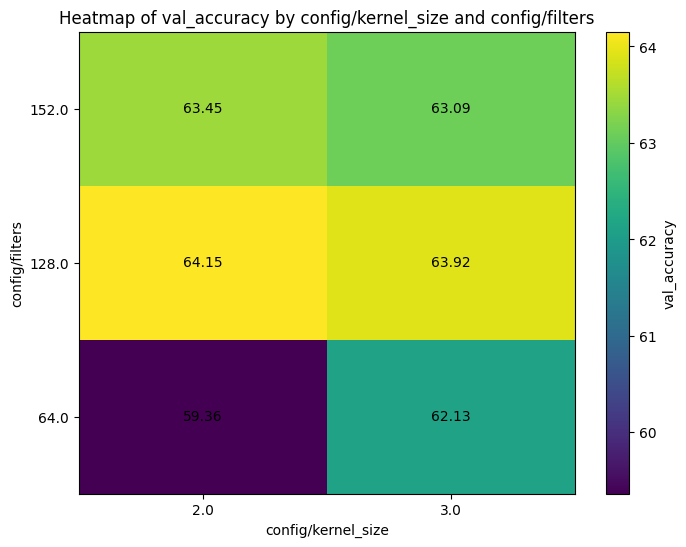

In [20]:
plot_heatmap(
    tune_df_structure,
    x="config/kernel_size",
    y="config/filters",
    z="val_accuracy"
)


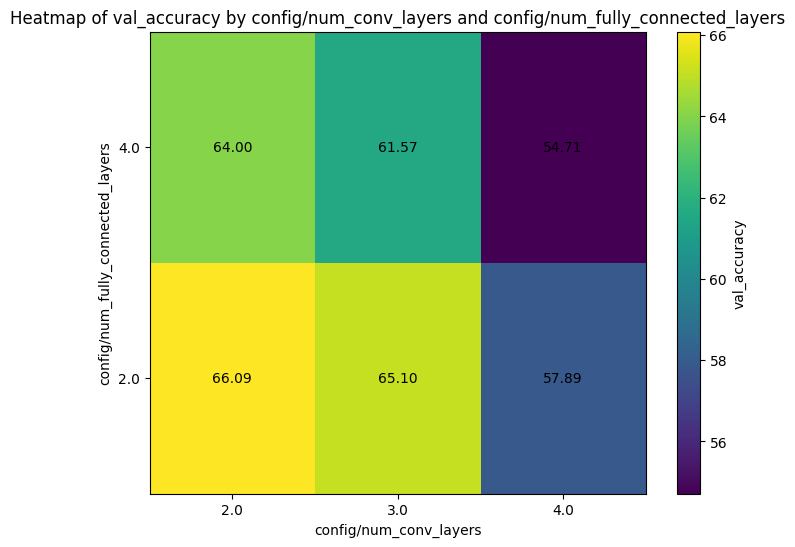

In [21]:
plot_heatmap(
    tune_df_structure,
    x="config/num_conv_layers",
    y="config/num_fully_connected_layers",
    z="val_accuracy",
)

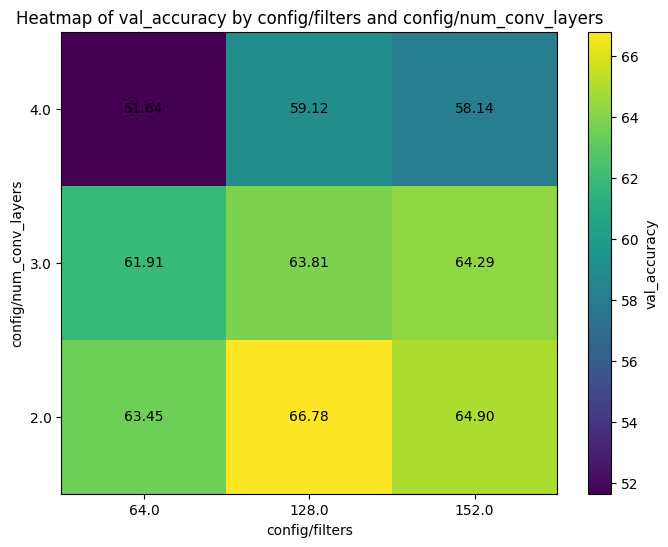

In [22]:
plot_heatmap(
    tune_df_structure,
    x="config/filters",
    y="config/num_conv_layers",
    z="val_accuracy",
)

In [23]:
tune_df_structure.sort_values("val_accuracy", ascending=False)

,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
0c81f_00001,0.877214,0.914536,68.920,68.29,1.761593e+09,NaN,True,3.0,2025-10-27_20-26-38,496.922892,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0
0c81f_00002,0.814518,0.891974,71.030,68.24,1.761594e+09,NaN,True,3.0,2025-10-27_20-31-52,499.112931,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,2.0,1.0,0.0
0c81f_00004,0.911675,0.917889,67.900,67.90,1.761593e+09,NaN,True,3.0,2025-10-27_20-27-34,511.481281,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,3.0,1.0,0.0
0c81f_00019,0.889029,0.930195,68.488,67.89,1.761593e+09,NaN,True,3.0,2025-10-27_20-28-08,507.948703,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,128.0,2.0,1.0,0.0
0c81f_00000,0.905180,0.927922,67.636,67.41,1.761592e+09,NaN,True,3.0,2025-10-27_20-12-40,242.827116,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,64.0,2.0,1.0,0.0
0c81f_00008,0.988399,0.941410,64.742,66.98,1.761594e+09,NaN,True,3.0,2025-10-27_20-33-51,487.312994,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3.0,152.0,2.0,1.0,0.0
0c81f_00010,0.994233,0.932681,64.724,66.56,1.761593e+09,NaN,True,3.0,2025-10-27_20-27-08,498.899277,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3.0,128.0,3.0,1.0,0.0
0c81f_00023,1.000532,0.980048,64.702,65.78,1.761594e+09,NaN,True,3.0,2025-10-27_20-37-55,244.964890,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,3.0,1.0,0.0
0c81f_00020,0.983315,0.970505,64.818,65.68,1.761594e+09,NaN,True,3.0,2025-10-27_20-33-00,502.232943,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2.0,152.0,2.0,1.0,0.0


In [24]:
from ray.tune.schedulers import AsyncHyperBandScheduler

config_hyperband = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "hidden_size": tune.randint(254, 512),
    "dropout": 0,
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # convolutional layer parameters
    "num_conv_layers": tune.grid_search([3]),
    "filters": tune.randint(100, 200),
    "kernel_size": tune.randint(2, 3),
    "stride": 1,
    "padding": tune.randint(0, 1),  # typical options for padding
}

# Create an AsyncHyperBandScheduler for efficient hyperparameter search
scheduler_hyperband = AsyncHyperBandScheduler(
    time_attr="training_iteration",  # attribute that tracks training progress
    grace_period=1,                  # start terminating after 3 epochs
    reduction_factor=2,              # half the number of models per epoch after grace_period
    max_t=config_hyperband["epochs"] # train for max 10 epochs
)

analysis_hyperband = tune.run(
    train_and_evaluate_ray,
    config=config_hyperband,
    name="cnn_hyperparameter_hyperband",
    metric="val_loss",
    mode="min",
    storage_path=str(config_hyperband["tune_dir"]),  # ensure path is string
    num_samples=20,
    verbose=1,
    scheduler=scheduler_hyperband,
    resume=True
)
tune_df_hyperband = analysis_hyperband.results_df.sort_values("val_loss")
tune_df_hyperband.head()

2025-10-30 08:22:43,183	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-29_08-24-34.json
2025-10-30 08:22:43,312	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_hyperband' in 0.0673s.
2025-10-30 08:22:43,318	INFO tune.py:1041 -- Total run time: 0.16 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
332a3_00019,0.348771,0.820794,87.592,74.81,1761597416,None,True,10,2025-10-27_21-36-56,180.862345,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,138,2,1,0
332a3_00011,0.399265,0.845756,85.752,73.92,1761597381,None,True,10,2025-10-27_21-36-21,184.783538,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,137,2,1,0
332a3_00002,0.554640,0.855870,80.348,71.57,1761596679,None,True,10,2025-10-27_21-24-39,133.745007,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,100,2,1,0
332a3_00016,0.419468,0.856166,85.176,73.73,1761597244,None,True,8,2025-10-27_21-34-04,224.548438,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,156,2,1,0
332a3_00007,0.335011,0.858112,88.076,74.70,1761597482,None,True,10,2025-10-27_21-38-02,168.436148,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,147,2,1,0


2025-10-30 08:22:43.392 | INFO     | __main__:<module>:4 - Best config: {'epochs': 10, 'data_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10'), 'tune_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune'), 'batch_size': 64, 'input_size': 3, 'output_size': 10, 'hidden_size': 390, 'dropout': 0, 'num_fully_connected_layers': 2, 'learning_rate': 0.001, 'loss_fn': CrossEntropyLoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'metrics': 'accuracy', 'device': 'cpu', 'num_conv_layers': 3, 'filters': 138, 'kernel_size': 2, 'stride': 1, 'padding': 0}
2025-10-30 08:22:43.436 | INFO     | __main__:train_and_evaluate:51 - Loaded best_cnn_model weights from saved_models/best_cnn_model.pth


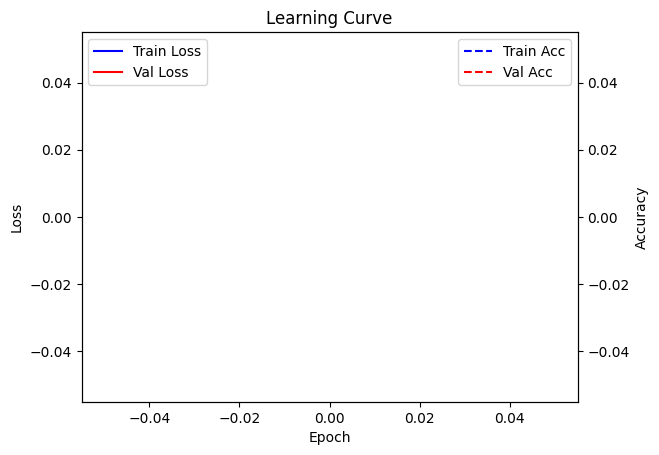

In [25]:
# Get the best config from the hyperband search
best_config = analysis_hyperband.get_best_config(metric="val_loss", mode="min")

logger.info(f"Best config: {best_config}")

# Instantiate the model with the best hyperparameters
best_model = SimpleCNN(
    input_size=best_config["input_size"],
    hidden_size=best_config["hidden_size"],
    output_size=best_config["output_size"],
    dropout=best_config["dropout"],
    num_conv_layers=best_config["num_conv_layers"],
    filters=best_config["filters"],
    kernel_size=best_config["kernel_size"],
    stride=best_config["stride"],
    padding=best_config["padding"],
    num_fully_connected_layers=best_config["num_fully_connected_layers"]
)

# Move model to device
device = best_config["device"]
best_model.to(device)
train_and_evaluate(best_model, best_config, logger, "best_cnn_model")
best_model.plot_learning_curve()

In [26]:
from ray.tune.schedulers import AsyncHyperBandScheduler

# Create an AsyncHyperBandScheduler for efficient hyperparameter search
scheduler_hyperband = AsyncHyperBandScheduler(
    time_attr="training_iteration",  # attribute that tracks training progress
    grace_period=1,                  # start terminating after 1 epoch
    reduction_factor=2,              # half the number of models per epoch after grace_period
    max_t=config_hyperband["epochs"] # train for max 10 epochs
)

# To avoid running out of memory, set 'reuse_actors' to True and limit 'max_concurrent_trials'.
# You can also reduce 'num_samples' or batch size if needed.

analysis_hyperband_transformers = tune.run(
    train_and_evaluate_ray_transformers,
    config=config_hyperband,
    name="cnn_hyperparameter_hyperband_transforms",
    metric="val_loss",
    mode="min",
    storage_path=str(config_hyperband["tune_dir"]),  # ensure path is string
    num_samples=20,
    verbose=1,
    scheduler=scheduler_hyperband,
    resume=True,
)
tune_df_hyperband_transformers = analysis_hyperband_transformers.results_df.sort_values("val_loss")
tune_df_hyperband_transformers.head()


2025-10-30 08:22:43,570	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-29_08-24-35.json
2025-10-30 08:22:43,699	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_hyperband_transforms' in 0.0681s.
2025-10-30 08:22:43,705	INFO tune.py:1041 -- Total run time: 0.16 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
4ad1d_00016,0.711261,0.765966,74.966,73.75,1761600591,None,True,10,2025-10-27_22-29-51,143.105479,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,103,2,1,0
4ad1d_00015,0.696219,0.775536,75.570,73.01,1761601426,None,True,10,2025-10-27_22-43-46,179.129944,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,152,2,1,0
4ad1d_00018,0.700257,0.777911,75.490,72.57,1761601713,None,True,10,2025-10-27_22-48-33,202.342930,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,171,2,1,0
4ad1d_00014,0.652288,0.778136,77.058,73.36,1761601107,None,True,10,2025-10-27_22-38-27,168.711790,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,136,2,1,0
4ad1d_00009,0.671620,0.787865,76.402,73.17,1761601732,None,True,10,2025-10-27_22-48-52,200.632060,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,3,179,2,1,0


2025-10-30 08:22:43.777 | INFO     | __main__:<module>:4 - Best config: {'epochs': 10, 'data_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10'), 'tune_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune'), 'batch_size': 64, 'input_size': 3, 'output_size': 10, 'hidden_size': 380, 'dropout': 0, 'num_fully_connected_layers': 2, 'learning_rate': 0.001, 'loss_fn': CrossEntropyLoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'metrics': 'accuracy', 'device': 'cpu', 'num_conv_layers': 3, 'filters': 103, 'kernel_size': 2, 'stride': 1, 'padding': 0}
2025-10-30 08:22:43.818 | INFO     | __main__:train_and_evaluate_transforms:87 - Loaded best_cnn_model_transforms weights from saved_models/best_cnn_model_transforms.pth


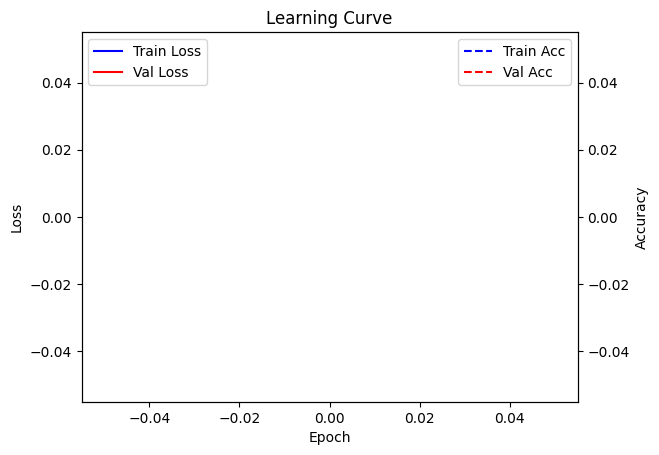

In [27]:
# Get the best config from the hyperband search
best_config = analysis_hyperband_transformers.get_best_config(metric="val_loss", mode="min")

logger.info(f"Best config: {best_config}")

# Instantiate the model with the best hyperparameters
best_model = SimpleCNN(
    input_size=best_config["input_size"],
    hidden_size=best_config["hidden_size"],
    output_size=best_config["output_size"],
    dropout=best_config["dropout"],
    num_conv_layers=best_config["num_conv_layers"],
    filters=best_config["filters"],
    kernel_size=best_config["kernel_size"],
    stride=best_config["stride"],
    padding=best_config["padding"],
    num_fully_connected_layers=best_config["num_fully_connected_layers"]
)

# Move model to device
device = best_config["device"]
best_model.to(device)
train_and_evaluate_transforms(best_model, best_config, logger, "best_cnn_model_transforms")
best_model.plot_learning_curve()

In [28]:
config_hyperparameters = {
    # Fixed parameters
    "epochs": 50,
    "data_dir": Path(DATADIR).resolve(),
    "tune_dir": Path(TUNEDIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "hidden_size": tune.randint(254, 512),
    "dropout": tune.choice([0.1, 0.2, 0.3]),
    "batchnorm": tune.choice([True, False]),
    "residual": tune.choice([True, False]),
    "num_fully_connected_layers": 2,
    "learning_rate": 0.001,
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": tune.choice([torch.optim.Adam, torch.optim.SGD]),
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    # convolutional layer parameters
    "num_conv_layers": 2,
    "filters": tune.randint(100, 250),
    "kernel_size": tune.randint(2, 3),
    "stride": 1,
    "padding": tune.randint(0, 1),  # typical options for padding
}

# Create an AsyncHyperBandScheduler for efficient hyperparameter search
scheduler_hyperpara = AsyncHyperBandScheduler(
    time_attr="training_iteration",  # attribute that tracks training progress
    grace_period=2,                  # start terminating after 3 epochs
    reduction_factor=2,              # half the number of models per epoch after grace_period
    max_t=config_hyperparameters["epochs"] # train for max 10 epochs
)

analysis_hyperparameters = tune.run(
    train_and_evaluate_ray_transformers,
    config=config_hyperparameters,
    name="cnn_hyperparameter_details",
    metric="val_loss",
    mode="min",
    storage_path=str(config_hyperparameters["tune_dir"]),  # ensure path is string
    num_samples=50,
    verbose=1,
    scheduler=scheduler_hyperpara,
    resume=True,
    raise_on_failed_trial=False,
    resources_per_trial={"cpu": 10},  # limit CPU/GPU per trial
    reuse_actors=True,                           # reuse actors to reduce memory
    max_concurrent_trials=4                      # limit concurrent trials
)
tune_df = analysis_hyperparameters.results_df.sort_values("val_loss")
tune_df.head()


2025-10-30 08:22:43,957	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2025-10-29_09-22-14.json
2025-10-30 08:22:44,185	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune/cnn_hyperparameter_details' in 0.1138s.
2025-10-30 08:22:44,205	INFO tune.py:1041 -- Total run time: 0.29 seconds (0.00 seconds for the tuning loop).


,train_loss,val_loss,train_accuracy,val_accuracy,timestamp,checkpoint_dir_name,done,training_iteration,date,time_this_iter_s,...,config/loss_fn,config/optimizer,config/scheduler,config/metrics,config/device,config/num_conv_layers,config/filters,config/kernel_size,config/stride,config/padding
trial_id,,,,,,,,,,,,,,,,,,,,,
1f9b5_00006,0.586128,0.706982,79.522,75.71,1761650208,None,True,50,2025-10-28_12-16-48,111.343782,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2,109,2,1,0
1f9b5_00007,0.594108,0.717107,79.166,75.37,1761652985,None,True,50,2025-10-28_13-03-05,76.415273,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2,118,2,1,0
1f9b5_00011,0.645315,0.723747,77.186,74.45,1761662773,None,True,50,2025-10-28_15-46-13,198.434523,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2,223,2,1,0
1f9b5_00027,0.560544,0.736519,80.248,74.74,1761669549,None,True,50,2025-10-28_17-39-09,84.515422,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2,107,2,1,0
1f9b5_00036,0.471210,0.757674,83.204,75.21,1761676647,None,True,32,2025-10-28_19-37-27,170.969113,...,CrossEntropyLoss(),<class 'torch.optim.adam.Adam'>,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,accuracy,cpu,2,204,2,1,0


2025-10-30 08:22:44.445 | INFO     | __main__:<module>:4 - Best config: {'epochs': 50, 'data_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/data/raw/cifar10'), 'tune_dir': PosixPath('/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/4-hypertuning-ray/hypertune'), 'batch_size': 64, 'input_size': 3, 'output_size': 10, 'hidden_size': 397, 'dropout': 0.3, 'batchnorm': False, 'residual': False, 'num_fully_connected_layers': 2, 'learning_rate': 0.001, 'loss_fn': CrossEntropyLoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'scheduler': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'metrics': 'accuracy', 'device': 'cpu', 'num_conv_layers': 2, 'filters': 109, 'kernel_size': 2, 'stride': 1, 'padding': 0}
2025-10-30 08:22:44.466 | INFO     | __main__:train_and_evaluate_transforms:87 - Loaded best_cnn_model_hyperparameters weights from saved_models/best_cnn_model_hyperparameters.pth


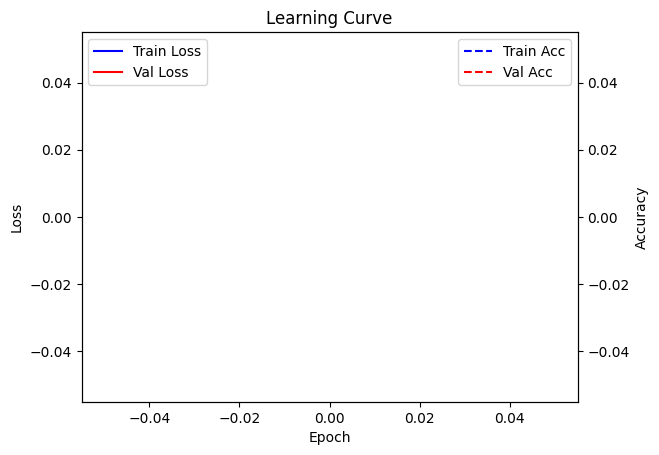

In [29]:
# Get the best config from the hyperband search
best_config = analysis_hyperparameters.get_best_config(metric="val_loss", mode="min")

logger.info(f"Best config: {best_config}")

# Instantiate the model with the best hyperparameters
best_model = SimpleCNN(
    input_size=best_config["input_size"],
    hidden_size=best_config["hidden_size"],
    output_size=best_config["output_size"],
    dropout=best_config["dropout"],
    num_conv_layers=best_config["num_conv_layers"],
    filters=best_config["filters"],
    kernel_size=best_config["kernel_size"],
    stride=best_config["stride"],
    padding=best_config["padding"],
    num_fully_connected_layers=best_config["num_fully_connected_layers"]
)

# Move model to device
device = best_config["device"]
best_model.to(device)
train_and_evaluate_transforms(best_model, best_config, logger, "best_cnn_model_hyperparameters")
best_model.plot_learning_curve()

In [32]:
# Try transfer learning with pretrained models
import torchvision.models as models

config_resnet = {
    # Fixed parameters
    "epochs": 10,
    "data_dir": Path(DATADIR).resolve(),
    "batch_size": 64,
    "input_size": 3,
    "output_size": 10,
    "learning_rate": 0.0001,  # Lower learning rate for fine-tuning
    "loss_fn": torch.nn.CrossEntropyLoss(), # suitable for multi-class classification
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "metrics": "accuracy",
    "device": "cuda" if torch.cuda.is_available() else "cpu", 
}

# Load a pre-trained ResNet model
model_resnet18 = models.resnet18(pretrained=True)
# Modify the final layer to match the number of classes in CIFAR-10
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, config_resnet["output_size"])
model_resnet18.to(config_resnet["device"])
train_and_evaluate_transforms(model_resnet18, config_resnet, logger, "resnet18")

if hasattr(model_resnet18, "train_losses") and model_resnet18.train_losses and model_resnet18.val_losses:
    model_resnet18.plot_learning_curve()

/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025-10-30 08:28:30.824 | INFO     | __main__:train_and_evaluate_transforms:87 - Loaded resnet18 weights from saved_models/resnet18.pth


In [33]:
# Load a pre-trained ResNet model
model_resnet34 = models.resnet34(pretrained=True)
# Modify the final layer to match the number of classes in CIFAR-10
model_resnet34.fc = nn.Linear(model_resnet34.fc.in_features, config_resnet["output_size"])
model_resnet34.to(config_resnet["device"])
train_and_evaluate_transforms(model_resnet34, config_resnet, logger, "resnet34")

if hasattr(model_resnet34, "train_losses") and model_resnet34.train_losses and model_resnet34.val_losses:
    model_resnet34.plot_learning_curve()

/mnt/WORKSPACE/kiei_workspace/master/UOS3/portfolio-DLDEPL01_2025/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
2025-10-30 08:28:37.091 | INFO     | __main__:train_and_evaluate_transforms:87 - Loaded resnet34 weights from saved_models/resnet34.pth


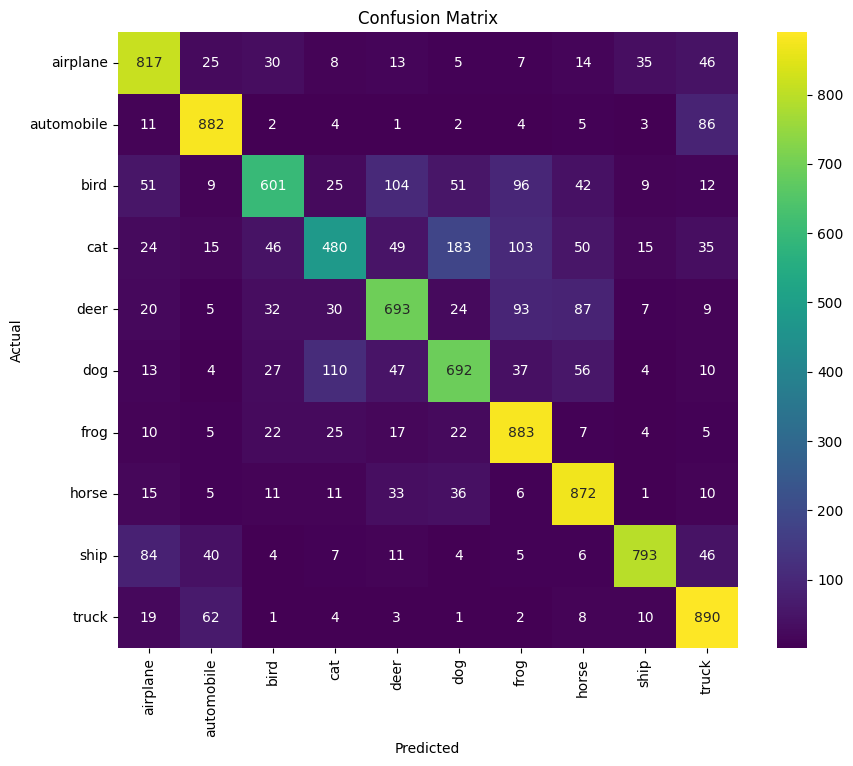

In [36]:
plot_confusion_matrix(best_model, best_config, classes)

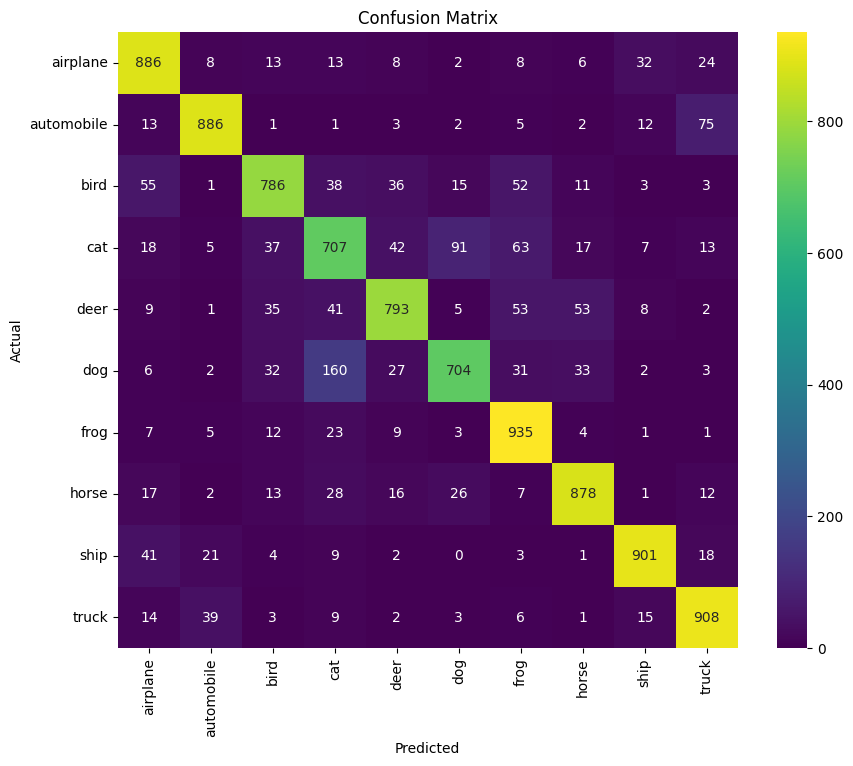

In [37]:
plot_confusion_matrix(model_resnet18, config_resnet, classes)

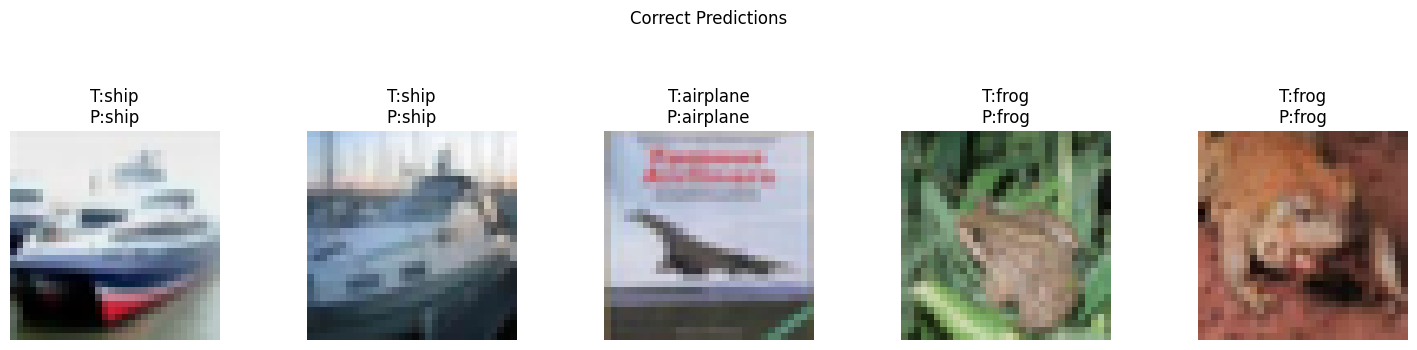

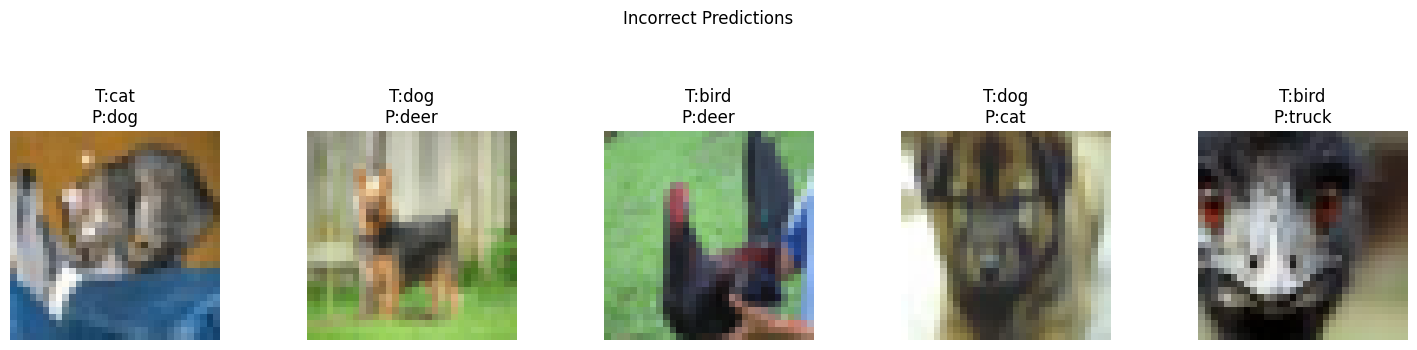

In [44]:
show_images_with_predictions(best_model, best_config, classes, num_images=5)

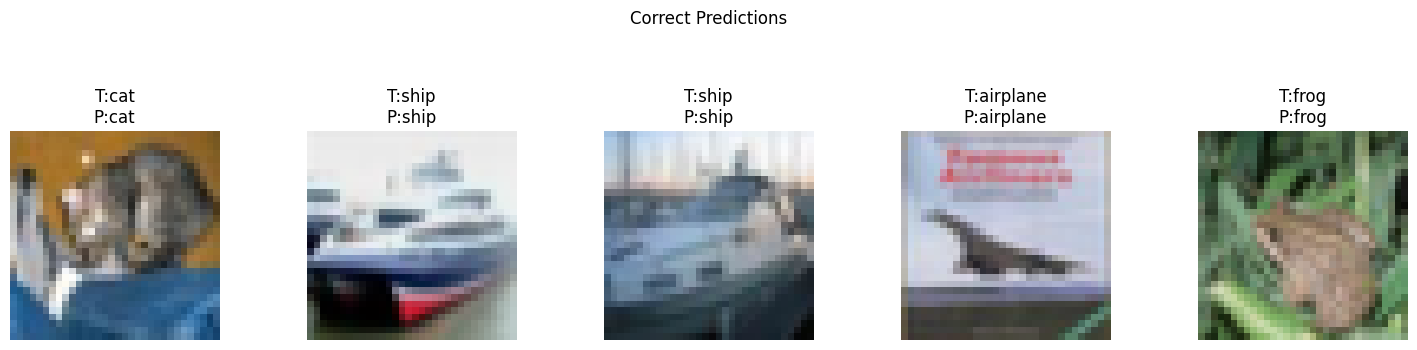

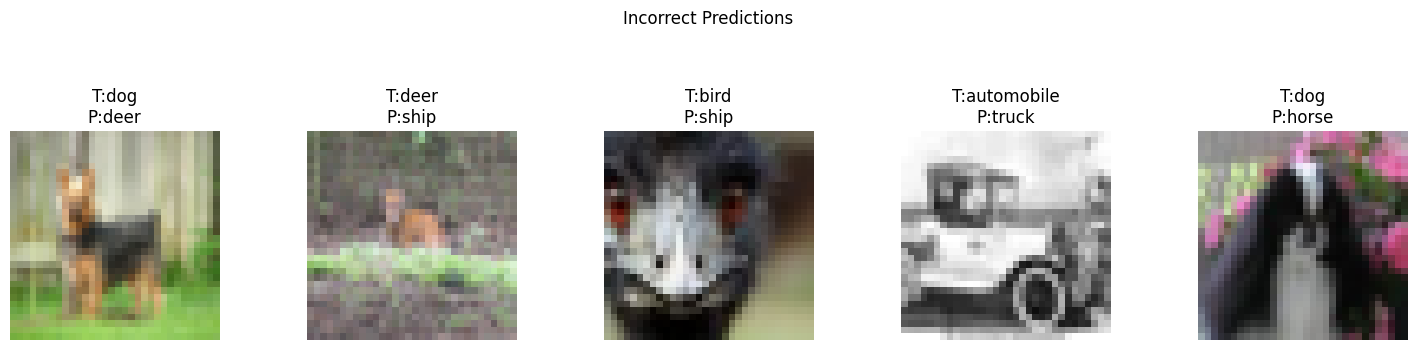

In [45]:
show_images_with_predictions(model_resnet18, config_resnet, classes, num_images=5)